In [56]:
from riotwatcher import LolWatcher, ApiError
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import kmeans_plusplus, KMeans, SpectralClustering
import numpy as np
from sklearn.metrics.cluster import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from collections import Counter, defaultdict
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler

In [57]:
df = pd.read_csv("../DataExtracted/ElyoyaDataV2.csv")
df

,gameId,timestamp,coordinate_x,coordinate_y,team,won
0,EUW1_6176366691,0.000000,557,345,Blue,True
1,EUW1_6176366691,1.000250,5633,9332,Blue,True
2,EUW1_6176366691,2.000750,8149,2265,Blue,True
3,EUW1_6176366691,3.001350,11532,4753,Blue,True
4,EUW1_6176366691,4.001617,11454,3261,Blue,True
...,...,...,...,...,...,...
2006,EUW1_6151765282,28.007417,10665,10235,Red,False
2007,EUW1_6151765282,29.007850,9714,5255,Red,False
2008,EUW1_6151765282,30.007983,7293,10934,Red,False
2009,EUW1_6151765282,31.008533,12258,8480,Red,False


Now that the data is collected from the riot API, I will start by seeing if there are any irregularities in the data.

Here the value_counts() function will be used because besides giving the information on how many player positions were collected in each match, it gives information on the games that were remaked and therefore will be removed. 

In [58]:
pd.set_option("display.max_rows", None)

df["gameId"].value_counts()

EUW1_6155602476    42
EUW1_6156430957    42
EUW1_6154372504    40
EUW1_6156848197    36
EUW1_6160920662    36
EUW1_6162595161    35
EUW1_6154165838    35
EUW1_6156713548    35
EUW1_6160614714    35
EUW1_6169361919    34
EUW1_6166201683    34
EUW1_6160122620    33
EUW1_6151765282    33
EUW1_6167017540    32
EUW1_6166266685    32
EUW1_6164815806    32
EUW1_6174116009    31
EUW1_6156559340    31
EUW1_6166357478    31
EUW1_6162519044    31
EUW1_6165754722    31
EUW1_6169720779    30
EUW1_6165735683    30
EUW1_6154019544    30
EUW1_6155233283    30
EUW1_6155459687    30
EUW1_6161351421    30
EUW1_6161484250    30
EUW1_6176366691    30
EUW1_6154082054    29
EUW1_6163819437    29
EUW1_6156652620    29
EUW1_6163695569    29
EUW1_6161274781    28
EUW1_6174897746    28
EUW1_6163920728    28
EUW1_6160146060    28
EUW1_6169332619    28
EUW1_6173376101    27
EUW1_6156508218    26
EUW1_6161529208    26
EUW1_6151839599    26
EUW1_6163787785    26
EUW1_6169961548    26
EUW1_6175455388    25
EUW1_61544

In [59]:
pd.set_option("display.max_rows", 10)

Looking at the number of player positions in each match, two games stood out for having less than 10 positions. Since the position of the player is collected every minute, this means that these two games have less than 10 minutes, and therefore means that the games did not happen (one team had a player that wasn't playing, which means that this team could give up the game)

With this being said, here EUW1_6166180735 and EUW1_6166247020 will be removed from the data frame.

In [60]:
df.drop(df[df['gameId'] == "EUW1_6166247020"].index, inplace = True)
df.drop(df[df['gameId'] == "EUW1_6166180735"].index, inplace = True)
df

,gameId,timestamp,coordinate_x,coordinate_y,team,won
0,EUW1_6176366691,0.000000,557,345,Blue,True
1,EUW1_6176366691,1.000250,5633,9332,Blue,True
2,EUW1_6176366691,2.000750,8149,2265,Blue,True
3,EUW1_6176366691,3.001350,11532,4753,Blue,True
4,EUW1_6176366691,4.001617,11454,3261,Blue,True
...,...,...,...,...,...,...
2006,EUW1_6151765282,28.007417,10665,10235,Red,False
2007,EUW1_6151765282,29.007850,9714,5255,Red,False
2008,EUW1_6151765282,30.007983,7293,10934,Red,False
2009,EUW1_6151765282,31.008533,12258,8480,Red,False


In [61]:
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i,c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = np.array(["blueviolet", "yellow", "lime", "crimson"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()

In [62]:
def clustering(df, scores = 0, bb = 0, bt = 0, rb = 0, rt = 0):
    scaler = StandardScaler()
    centroids = np.array([[8250, 4250, 0], [4000, 8750, 0],[12000, 7500, 0], [7750, 12000, 0]])
    centroids_scaled = scaler.fit_transform(centroids)
    nc = df.shape[1]
    df_array = df.values
    X = df_array[:, 1:4]
    X_scaled = scaler.fit_transform(X)
    kms = KMeans(n_clusters=4, init= centroids_scaled, n_init=1, random_state=0, algorithm="elkan").fit(X_scaled)
    label = kms.fit_predict(X_scaled)

    #---------------
    #plot clusters
    centroids2 = kms.cluster_centers_
    u_labels = np.unique(label)
    img = plt.imread("../map11.png")
    fig, ax = plt.subplots()
    ax.imshow(img, extent=[0, 16000, 0, 16000])
    
    #plotting the results:
    
    for i in u_labels:
        ax.scatter(X[label == i , 1] , X[label == i , 2] , label = i, color = np.array(["blueviolet", "yellow", "lime", "crimson"])[i])
    ax.legend(frameon = True)
    plt.grid(visible=None)
    plt.show()
    if(scores != 0):
        scores.append(silhouette_score(X_scaled, kms.labels_))

    if(bb != 0):
        bb.append(Counter(kms.labels_).get(0))
        bt.append(Counter(kms.labels_).get(1))
        rb.append(Counter(kms.labels_).get(2))
        rt.append(Counter(kms.labels_).get(3))
    drawSillouette(X_scaled, kms.labels_, "kmeans (K=4)")

    print("Kmeans silhouette_score", silhouette_score(X_scaled, kms.labels_))
    print("Locations in cluster 0: {}\nLocations in cluster 1: {}\nLocations in cluster 2: {}\nLocations in cluster 3: {}\n".format(Counter(kms.labels_).get(0),Counter(kms.labels_).get(1),Counter(kms.labels_).get(2),Counter(kms.labels_).get(3)))
    print("--------------------------------------------------------------------------------------")
    #blueviolet - blue team's bot jungle
    #yellow - blue team's top jungle
    #lime - red team's bot jungle
    #crimson - red team's top jungle

In [63]:
df.drop(df[(df['coordinate_x'] <= 6000) & (df["coordinate_y"] <= 6000)].index, inplace = True)
df.drop(df[(df['coordinate_x'] >= 10500) & (df["coordinate_y"] >= 10500)].index, inplace = True)
df

,gameId,timestamp,coordinate_x,coordinate_y,team,won
1,EUW1_6176366691,1.000250,5633,9332,Blue,True
2,EUW1_6176366691,2.000750,8149,2265,Blue,True
3,EUW1_6176366691,3.001350,11532,4753,Blue,True
4,EUW1_6176366691,4.001617,11454,3261,Blue,True
5,EUW1_6176366691,5.001633,1232,13514,Blue,True
...,...,...,...,...,...,...
2005,EUW1_6151765282,27.007400,7572,12304,Red,False
2006,EUW1_6151765282,28.007417,10665,10235,Red,False
2007,EUW1_6151765282,29.007850,9714,5255,Red,False
2008,EUW1_6151765282,30.007983,7293,10934,Red,False


In [64]:
redTeam_df = df.loc[df["team"] == "Red"]
print("Red Team Data Frame:\n{}".format(redTeam_df))
print("\nElyoya played {} matches on the red team.".format(redTeam_df["gameId"].nunique()))

Red Team Data Frame:
               gameId  timestamp  coordinate_x  coordinate_y team    won
31    EUW1_6176325099   1.000250          9667          7063  Red  False
32    EUW1_6176325099   2.000350          8037          3520  Red  False
33    EUW1_6176325099   3.000583         11663          7725  Red  False
34    EUW1_6176325099   4.000900          7672          5223  Red  False
35    EUW1_6176325099   5.001633          3604         13800  Red  False
...               ...        ...           ...           ...  ...    ...
2005  EUW1_6151765282  27.007400          7572         12304  Red  False
2006  EUW1_6151765282  28.007417         10665         10235  Red  False
2007  EUW1_6151765282  29.007850          9714          5255  Red  False
2008  EUW1_6151765282  30.007983          7293         10934  Red  False
2009  EUW1_6151765282  31.008533         12258          8480  Red  False

[756 rows x 6 columns]

Elyoya played 33 matches on the red team.


In [65]:
redTeamWins_df = redTeam_df.loc[redTeam_df["won"] == True]
print("Red Team Winning Data Frame:\n{}".format(redTeamWins_df))

print("\nElyoya won {} matches on the red team.".format(redTeamWins_df["gameId"].nunique()))

Red Team Winning Data Frame:
               gameId  timestamp  coordinate_x  coordinate_y team   won
160   EUW1_6173376101   1.000200          7269          9759  Red  True
161   EUW1_6173376101   2.000483          7219         12424  Red  True
162   EUW1_6173376101   3.001183         11854          6708  Red  True
163   EUW1_6173376101   4.001733         10439         13946  Red  True
164   EUW1_6173376101   5.002283          3693          6591  Red  True
...               ...        ...           ...           ...  ...   ...
1860  EUW1_6154165838  27.008967         10968          8450  Red  True
1861  EUW1_6154165838  28.009083          8532          4744  Red  True
1862  EUW1_6154165838  29.009500          7563          9749  Red  True
1865  EUW1_6154165838  32.010183          7520          7674  Red  True
1866  EUW1_6154165838  33.010350          9017          6192  Red  True

[387 rows x 6 columns]

Elyoya won 17 matches on the red team.


In [66]:
""" X_scaled = []
for game in redTeamWins_df.gameId.unique():
    scaler = StandardScaler()
    game_df = df.loc[df["gameId"] == game]
    df_array = game_df.values
    X = df_array[:, 1:4]
    X_scaled = scaler.fit_transform(X)
    break

df_scaled = pd.DataFrame(X_scaled, columns=[
  'timestamp', 'coordinate_x', 'coordinate_y'])

df_scaled
  """

' X_scaled = []\nfor game in redTeamWins_df.gameId.unique():\n    scaler = StandardScaler()\n    game_df = df.loc[df["gameId"] == game]\n    df_array = game_df.values\n    X = df_array[:, 1:4]\n    X_scaled = scaler.fit_transform(X)\n    break\n\ndf_scaled = pd.DataFrame(X_scaled, columns=[\n  \'timestamp\', \'coordinate_x\', \'coordinate_y\'])\n\ndf_scaled\n  '

1: EUW1_6173376101 - Red team Victory
Number of points:  24


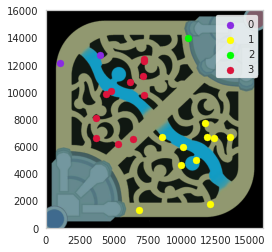

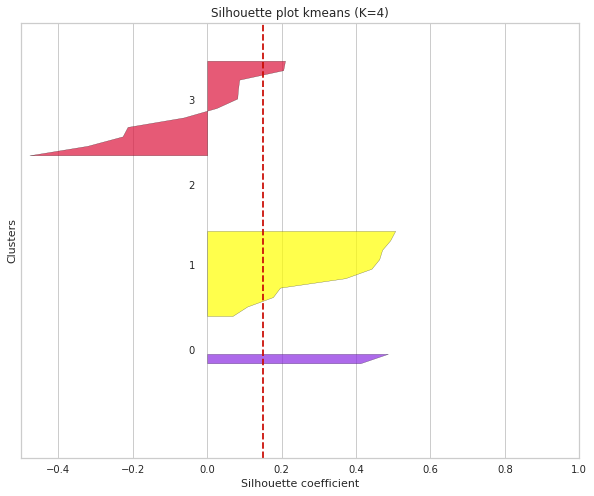

Kmeans silhouette_score 0.14876587709936082
Locations in cluster 0: 2
Locations in cluster 1: 10
Locations in cluster 2: 1
Locations in cluster 3: 11

--------------------------------------------------------------------------------------
2: EUW1_6170116709 - Red team Victory
Number of points:  18


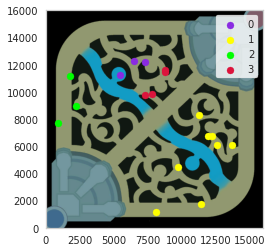

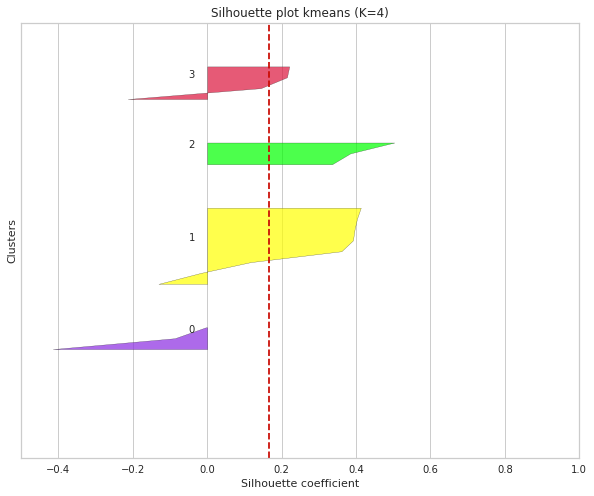

Kmeans silhouette_score 0.16743411126575003
Locations in cluster 0: 3
Locations in cluster 1: 8
Locations in cluster 2: 3
Locations in cluster 3: 4

--------------------------------------------------------------------------------------
3: EUW1_6169961548 - Red team Victory
Number of points:  18


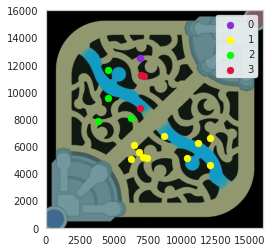

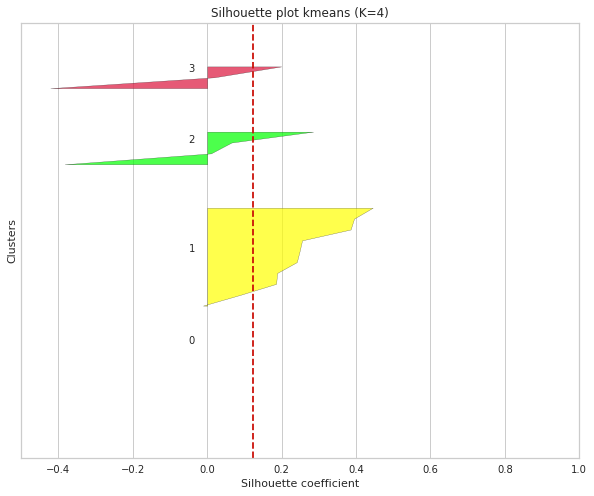

Kmeans silhouette_score 0.12191016268755867
Locations in cluster 0: 1
Locations in cluster 1: 10
Locations in cluster 2: 4
Locations in cluster 3: 3

--------------------------------------------------------------------------------------
4: EUW1_6169756315 - Red team Victory
Number of points:  15


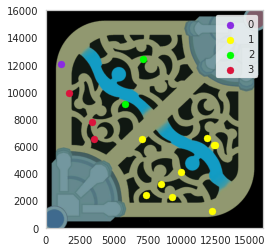

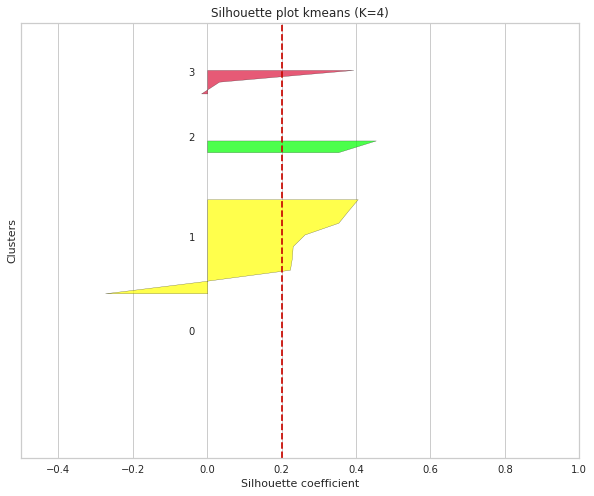

Kmeans silhouette_score 0.19987057617554266
Locations in cluster 0: 1
Locations in cluster 1: 9
Locations in cluster 2: 2
Locations in cluster 3: 3

--------------------------------------------------------------------------------------
5: EUW1_6169361919 - Red team Victory
Number of points:  23


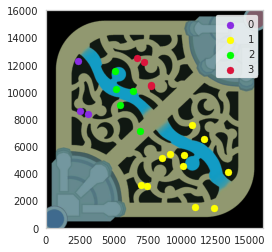

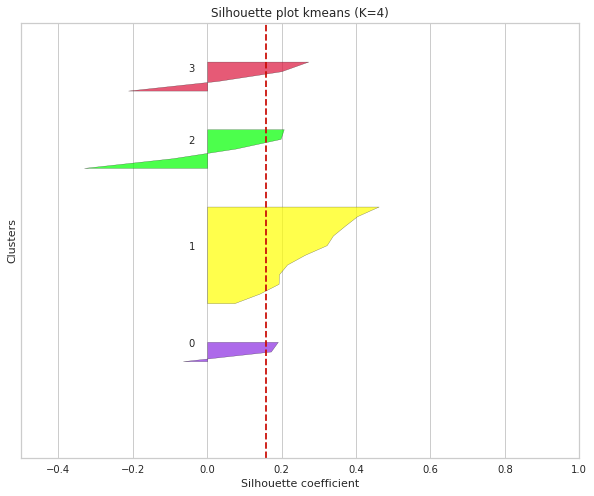

Kmeans silhouette_score 0.1567663595325481
Locations in cluster 0: 3
Locations in cluster 1: 11
Locations in cluster 2: 5
Locations in cluster 3: 4

--------------------------------------------------------------------------------------
6: EUW1_6169332619 - Red team Victory
Number of points:  23


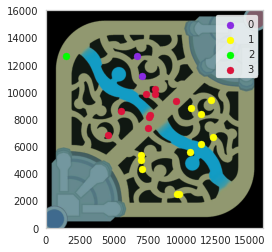

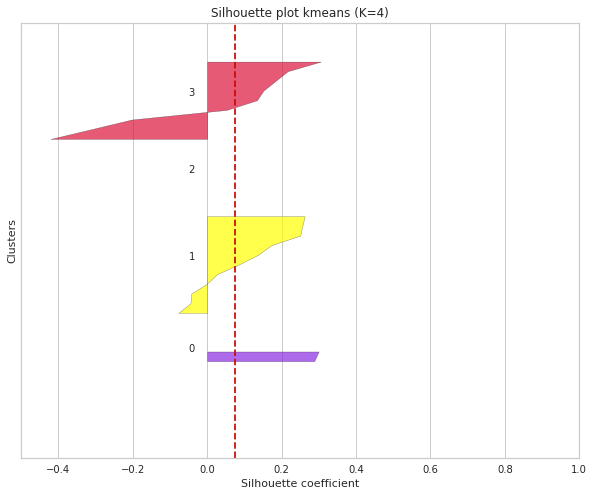

Kmeans silhouette_score 0.07455767971120257
Locations in cluster 0: 2
Locations in cluster 1: 11
Locations in cluster 2: 1
Locations in cluster 3: 9

--------------------------------------------------------------------------------------
7: EUW1_6166266685 - Red team Victory
Number of points:  26


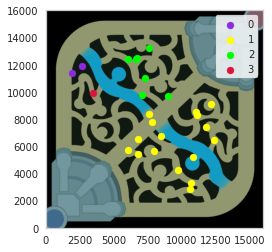

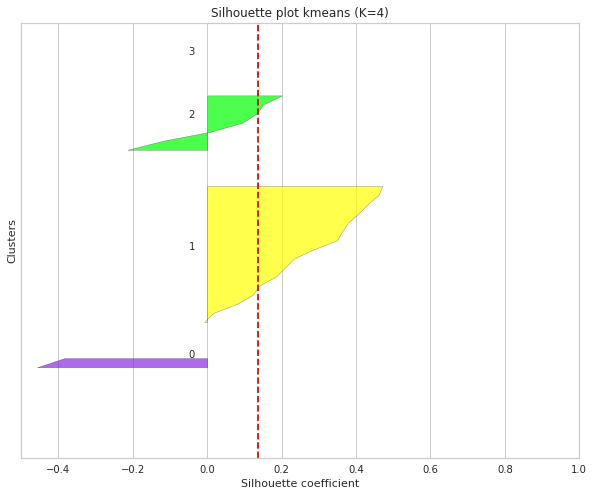

Kmeans silhouette_score 0.1361929255177161
Locations in cluster 0: 2
Locations in cluster 1: 16
Locations in cluster 2: 7
Locations in cluster 3: 1

--------------------------------------------------------------------------------------
8: EUW1_6166201683 - Red team Victory
Number of points:  27


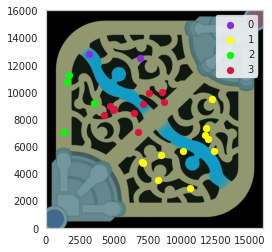

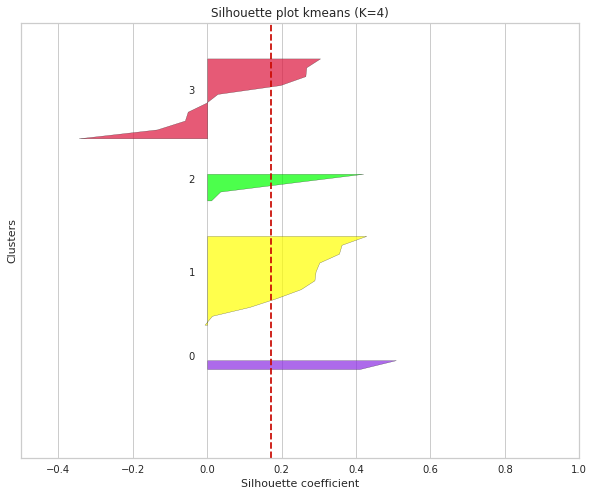

Kmeans silhouette_score 0.17222470364973588
Locations in cluster 0: 2
Locations in cluster 1: 11
Locations in cluster 2: 4
Locations in cluster 3: 10

--------------------------------------------------------------------------------------
9: EUW1_6165754722 - Red team Victory
Number of points:  24


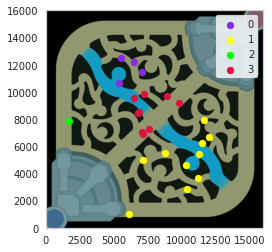

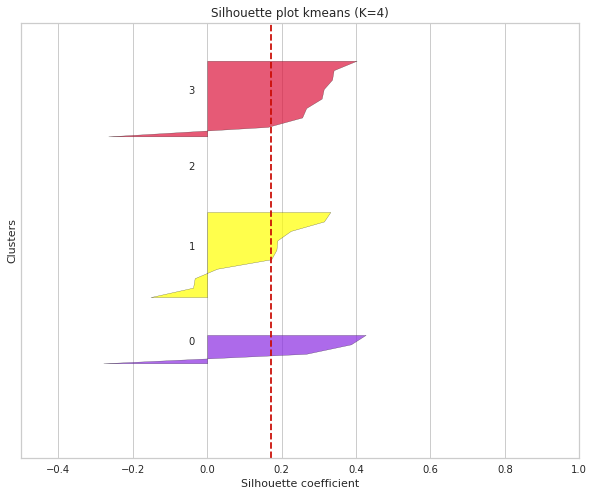

Kmeans silhouette_score 0.1722167270122915
Locations in cluster 0: 4
Locations in cluster 1: 10
Locations in cluster 2: 1
Locations in cluster 3: 9

--------------------------------------------------------------------------------------
10: EUW1_6165735683 - Red team Victory
Number of points:  25


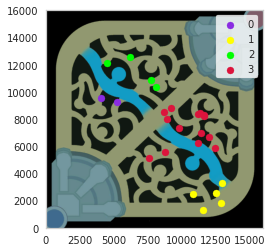

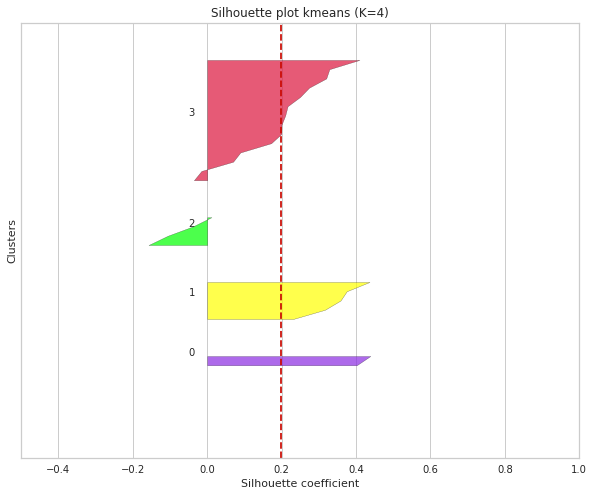

Kmeans silhouette_score 0.19802025410905175
Locations in cluster 0: 2
Locations in cluster 1: 5
Locations in cluster 2: 4
Locations in cluster 3: 14

--------------------------------------------------------------------------------------
11: EUW1_6163695569 - Red team Victory
Number of points:  25


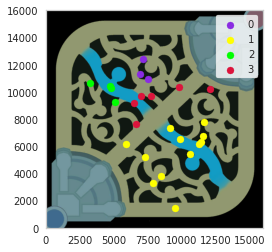

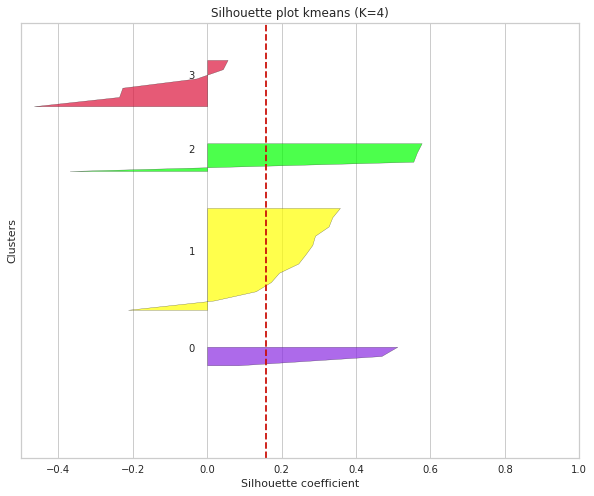

Kmeans silhouette_score 0.15699368063460828
Locations in cluster 0: 3
Locations in cluster 1: 12
Locations in cluster 2: 4
Locations in cluster 3: 6

--------------------------------------------------------------------------------------
12: EUW1_6163629472 - Red team Victory
Number of points:  18


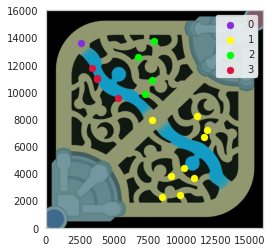

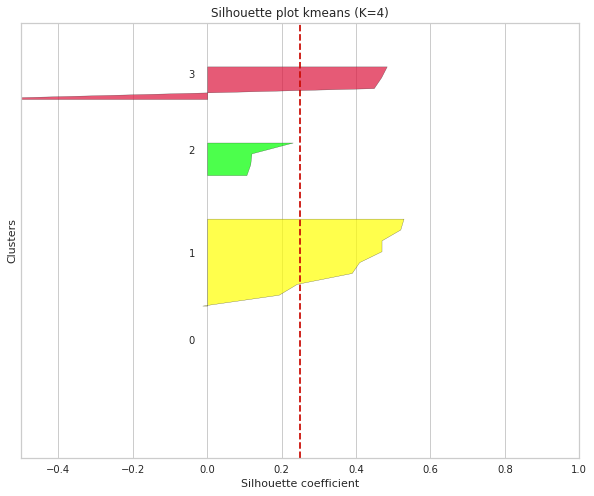

Kmeans silhouette_score 0.2483211130544644
Locations in cluster 0: 1
Locations in cluster 1: 9
Locations in cluster 2: 4
Locations in cluster 3: 4

--------------------------------------------------------------------------------------
13: EUW1_6162595161 - Red team Victory
Number of points:  29


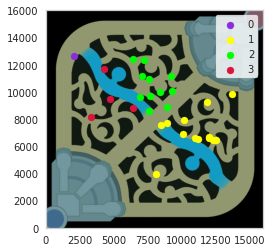

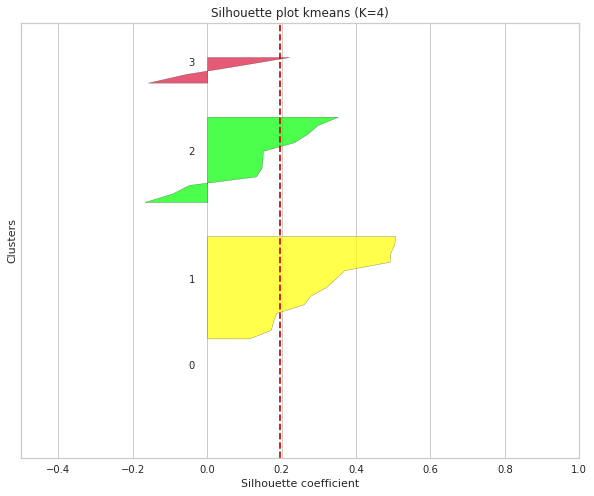

Kmeans silhouette_score 0.19667051184903134
Locations in cluster 0: 1
Locations in cluster 1: 13
Locations in cluster 2: 11
Locations in cluster 3: 4

--------------------------------------------------------------------------------------
14: EUW1_6156713548 - Red team Victory
Number of points:  25


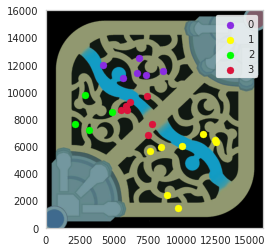

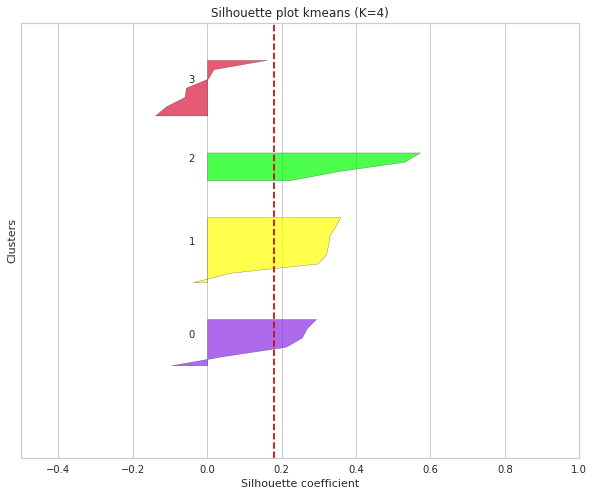

Kmeans silhouette_score 0.1782902300198948
Locations in cluster 0: 6
Locations in cluster 1: 8
Locations in cluster 2: 4
Locations in cluster 3: 7

--------------------------------------------------------------------------------------
15: EUW1_6155318816 - Red team Victory
Number of points:  22


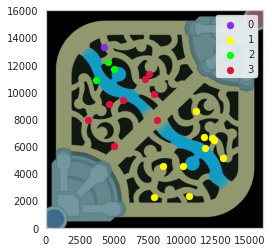

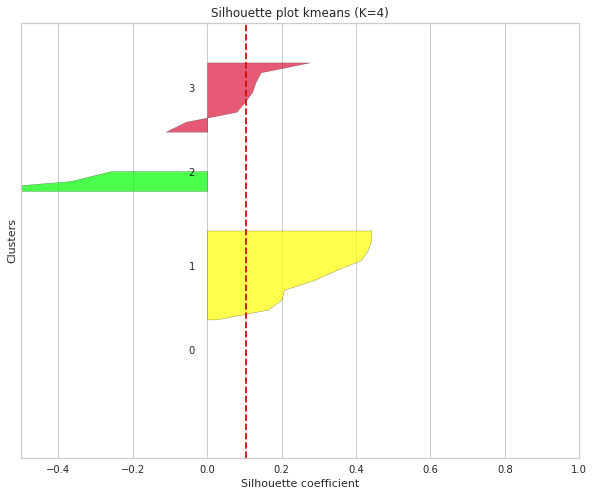

Kmeans silhouette_score 0.10538725324715661
Locations in cluster 0: 1
Locations in cluster 1: 10
Locations in cluster 2: 3
Locations in cluster 3: 8

--------------------------------------------------------------------------------------
16: EUW1_6154241292 - Red team Victory
Number of points:  18


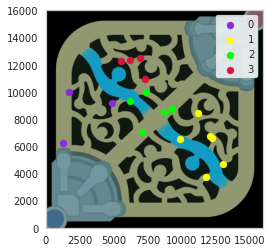

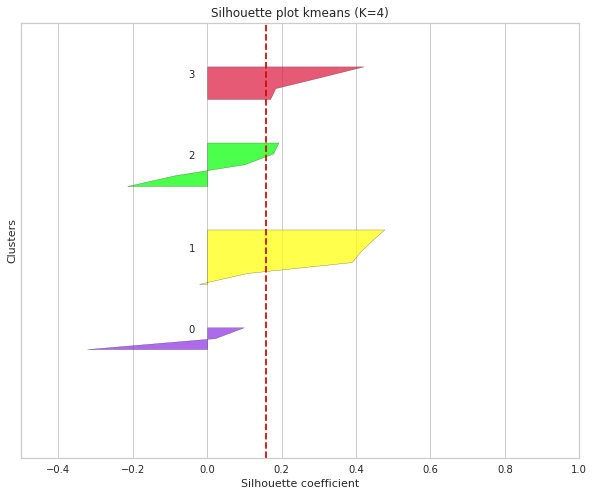

Kmeans silhouette_score 0.15806394203961663
Locations in cluster 0: 3
Locations in cluster 1: 6
Locations in cluster 2: 5
Locations in cluster 3: 4

--------------------------------------------------------------------------------------
17: EUW1_6154165838 - Red team Victory
Number of points:  27


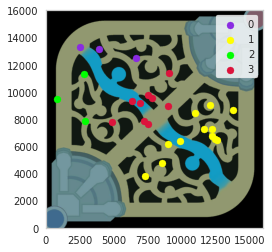

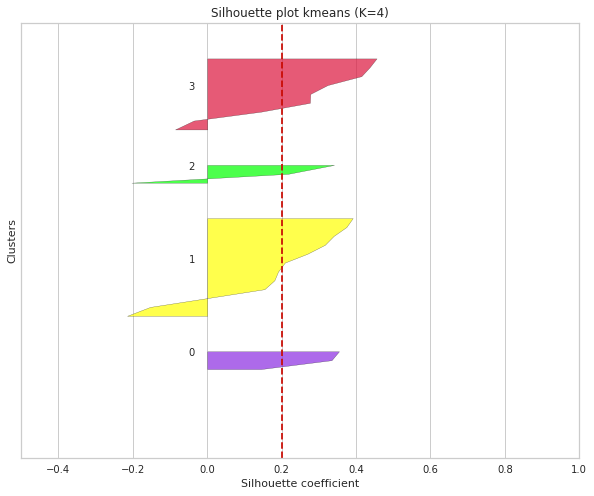

Kmeans silhouette_score 0.20178122508436355
Locations in cluster 0: 3
Locations in cluster 1: 12
Locations in cluster 2: 3
Locations in cluster 3: 9

--------------------------------------------------------------------------------------


In [67]:
n = 1
scores = []
npoints = []
bb = []
bt = []
rb = []
rt = []
for game in redTeamWins_df.gameId.unique():
    game_df = df.loc[df["gameId"] == game]
    print("{}: {} - {} team Victory".format(n, game, game_df["team"].unique()[0]))
    print("Number of points: ", game_df.shape[0])
    npoints.append(game_df.shape[0])
    clustering(game_df, scores, bb, bt, rb, rt)
    n += 1

In [68]:
mean = np.mean(np.array(scores))
avPoints = np.mean(np.array(npoints))
avBb = np.sum(np.array(bb))
avBt = np.sum(np.array(bt))
avRb = np.sum(np.array(rb))
avRt = np.sum(np.array(rt))
print("When Red team Wins:")
print(" - Average silhouette score: ", mean)
print(" - Average points: ", avPoints)
print(" - Average points on the blue team's bottom jungle: ", avBb)
print(" - Average points on the blue team's top jungle: ", avBt)
print(" - Average points on the red team's bottom jungle: ", avRb)
print(" - Average points on the red team's top jungle: ", avRt)

When Red team Wins:
 - Average silhouette score:  0.16432160780528784
 - Average points:  22.764705882352942
 - Average points on the blue team's bottom jungle:  40
 - Average points on the blue team's top jungle:  171
 - Average points on the red team's bottom jungle:  66
 - Average points on the red team's top jungle:  110


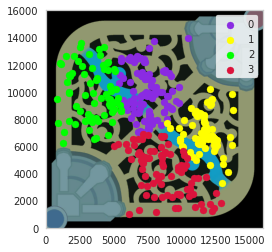

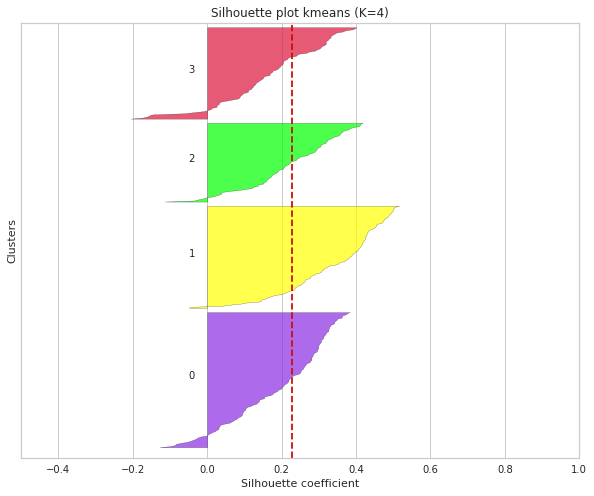

Kmeans silhouette_score 0.22880362893584943
Locations in cluster 0: 128
Locations in cluster 1: 97
Locations in cluster 2: 75
Locations in cluster 3: 87

--------------------------------------------------------------------------------------


In [69]:
clustering(redTeamWins_df)